# 1. Unconstrained optimization

In [1]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize
sp.init_printing()
from math import exp
import matplotlib.pyplot as plt
#from IPython.html.widgets import interact
from IPython.html.widgets import interact, FloatSlider, RadioButtons
%matplotlib inline

//anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Some benchmarks

We will use two benchmarks to demonstrate in class.

In [2]:
def plot_contour(f, xlim, ylim, ax):
    '''
    Plots the contour of a 2D function to be minimized
    '''
    xvals = np.linspace(*xlim)
    yvals = np.linspace(*ylim)
    X, Y = np.meshgrid(xvals, yvals)
    Z = np.reshape(map(f, zip(X.ravel().tolist(), Y.ravel().tolist())), X.shape)
    ax.contour(X, Y, Z)
    ax.contourf(X, Y, Z, cmap='bone')


def add_path(ax, x_steps, col='b'):
    '''
    Adds a path of an opitmization algorithm to a figure
    '''
    X = np.concatenate(x_steps, axis=1)
    ax.plot(X[0], X[1], c=col)

Simple quadratic problem:

$$
f(x_1, x_2) = \frac{1}{2} (x_1^2 +\gamma x_2^2)\,,
$$
where $\gamma$ determines the condition number.

In [3]:
def quadratic(x, gamma=10):
    return 0.5 * (x[0]**2 + gamma * x[1]**2)

def grad_quadratic(x, gamma=10):
    return np.array([[x[0,0]], [gamma * x[1,0]]])

def hessian_quadratic(x, gamma=10):
    return np.array([[1, 0], [0, gamma]])

A non-quadratic function:
$$
f(x_1, x_2) = e^{x_1 +3x_2-0.1}+e^{x_1 -3x_2-0.1}+e^{-x_1 -0.1}\,.
$$

In [6]:
x1_, x2_ = sp.symbols('x1, x2')

nonquad_expr = sp.log(sp.exp(x1_ + 3*x2_ - 0.1) + sp.exp(x1_-3*x2_-0.1) + sp.exp(-x1_ - 0.1))
nonquadratic_f = sp.lambdify((x1_, x2_), nonquad_expr, np)
nonquadratic = lambda x : nonquadratic_f(x[0],x[1])
grad_nonquadratic_f = sp.lambdify((x1_, x2_), [nonquad_expr.diff(x1_), nonquad_expr.diff(x2_)], np)
grad_nonquadratic = lambda x : np.array(grad_nonquadratic_f(x[0], x[1])).reshape((-1, 1))

nqdx1dx1 = sp.lambdify((x1_, x2_), nonquad_expr.diff(x1_).diff(x1_), np)
nqdx1dx2 = sp.lambdify((x1_, x2_), nonquad_expr.diff(x1_).diff(x2_), np)
nqdx2dx2 = sp.lambdify((x1_, x2_), nonquad_expr.diff(x2_).diff(x2_), np)

def hessian_nonquadratic(x):
    return np.array([[nqdx1dx1(x[0,:], x[1,:]), nqdx1dx2(x[0,:], x[1,:])], 
                     [nqdx1dx2(x[0], x[1]), nqdx2dx2(x[0], x[1])]]).reshape(2,2)

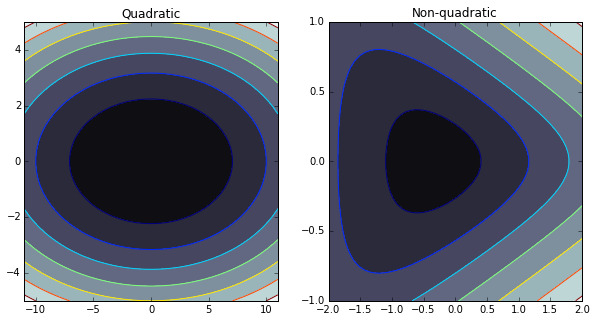

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plot_contour(quadratic, (-11, 11), (-5, 5), ax1)
ax1.set_title('Quadratic')
plot_contour(nonquadratic, (-2, 2), (-1, 1), ax2)
ax2.set_title('Non-quadratic')

## Line search using backtracking

In [9]:
def backtracking_line_search(funct, x0, dx, dfx0, t0, alpha=0.1, beta=0.7):
    '''
    Uses backtracking for finding the minimum over a line.
    Inputs: 
        - f: function to be searched over a line
        - x0: initial point
        - dx: direction to search
        - dfx0: gradient of f in x0
        - t0: initial (maximal) value of t to backtrack
        - alpha
        - beta
    Outputs:
        - t: suggested stepsize
        - x_steps: list with the steps taken
        - f_values: list with corresponding values
    '''
    t = t0
    x_steps = [x0 + t * dx]
    f_values  = [funct(x0 + t * dx)]
    fx0 = funct(x0)
    while f_values[-1] > fx0 + alpha * t * np.transpose(dfx0).dot(dx):
        t *= beta
        x_steps.append(x0 + t * dx)
        f_values.append(funct(x0 + t * dx))
    return t, x_steps, f_values

In [10]:
def demonstrate_bls(alpha, beta):
    xvals = np.linspace(-2, 2, 100)
    f = lambda x : x**2
    df = lambda x : 2*x
    x0 = -1
    yvals = map(f, xvals)
    fig, ax = plt.subplots()
    ax.plot(xvals, yvals, label='function')
    t, x_steps, f_values = backtracking_line_search(f, x0, -df(x0), df(x0), 4, alpha, beta)
    ax.plot(x_steps, f_values, label='bt line search')
    ax.scatter(x0-t*df(x0), f(x0-t*df(x0)), label='returned min')
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc=0)
    print 'Number of steps: %i' %len(x_steps)
    print 'Returned minimum is %s' %(x0-t*df(x0))

Number of steps: 4
Returned minimum is 0.0


<function __main__.demonstrate_bls>

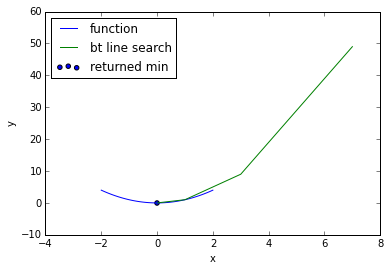

In [11]:
interact(demonstrate_bls,
         alpha=FloatSlider(value=0.2, min=0.01, max=0.5, step=0.02),
         beta=FloatSlider(value=0.5, min=0.3, max=0.8, step=0.05))

## Gradient descent 

In [12]:
def gradient_descent(f, x0, df, alpha=0.05, beta=0.6, nu=1e-3, trace=False):
    '''
    General gradient descent algorithm.
    Inputs:
        - f: function to be minimized
        - x0: starting point
        - df: gradient of the function to be minimized
        - alpha: parameter for btls
        - beta: parameter for btls
        - nu: parameter to determine if the algortihm is convered
        - trace: (bool) store the path that is followed?
    Outputs:
        - xstar: the found minimum
        - x_steps: path in the domain that is followed (if trace=True)
        - f_steps: image of x_steps (if trace=True)
    '''
    x = x0  # initial value
    if trace: x_steps = [x0.copy()]
    if trace: f_steps = [f(x0)]
    while True:
        dfx = df(x)
        dx = - dfx  # choose direction
        if np.linalg.norm(dx) < nu:
            break  # converged
        t, _, _ = backtracking_line_search(f, x, dx, dfx, 1, alpha, beta)
        x += t * dx
        if trace: x_steps.append(x.copy())
        if trace: f_steps.append(f(x))
    if trace: return x, x_steps, f_steps
    else: return x

Number of steps quadratic function: 76
Number of steps non-quadratic function: 34


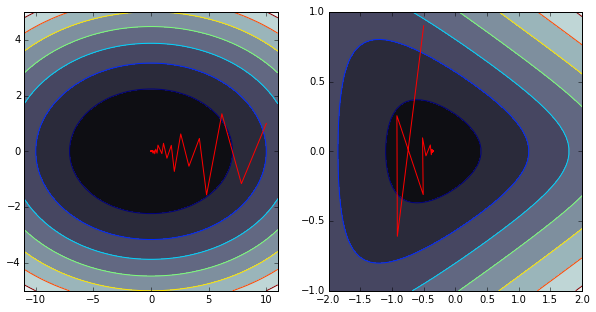

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plot_contour(quadratic, (-11, 11), (-5, 5), ax1)
plot_contour(nonquadratic, (-2, 2), (-1, 1), ax2)

xstar_q, x_steps_q, f_steps_q = gradient_descent(quadratic, np.array([[10.0], [1.0]]), grad_quadratic, nu=1e-6, trace=True)
add_path(ax1, x_steps_q, 'red')

print 'Number of steps quadratic function: %i' %len(x_steps_q)

xstar_nq, x_steps_nq, f_steps_nq = gradient_descent(nonquadratic, np.array([[-0.5], [0.9]]), grad_nonquadratic, nu=1e-6, trace=True)
add_path(ax2, x_steps_nq, 'red')

print 'Number of steps non-quadratic function: %i' %len(f_steps_nq)


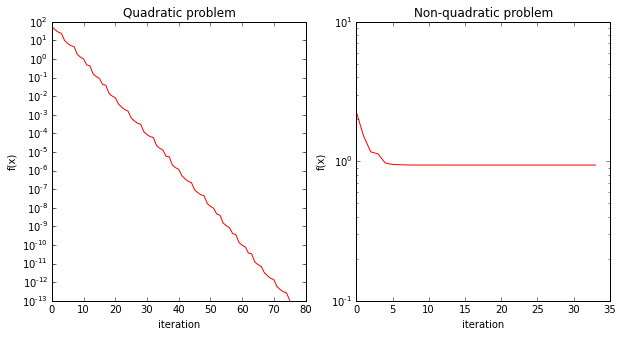

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.plot(f_steps_q, c='red')
ax1.set_title('Quadratic problem')
ax2.plot(f_steps_nq, c='red')
ax2.set_title('Non-quadratic problem')
for ax in (ax1, ax2):
    ax.set_xlabel('iteration')
    ax.set_ylabel('f(x)')
    ax.semilogy()

## Newton's method

In [15]:
def newtons_method(f, x0, df, ddf, alpha=0.3, beta=0.8, epsilon=1e-3, trace=False, inverse_hess=False):
    '''
    Newton's method for minimizing functions.
    Inputs:
        - f: function to be minimized
        - x0: starting point
        - df: gradient of the function to be minimized
        - dff: hessian matrix of the function to be minimized
        - alpha: parameter for btls
        - beta: parameter for btls
        - nu: parameter to determine if the algortihm is convered
        - trace: (bool) store the path that is followed?
        - inverse_hess: set to true if the inverse of hessian is provided
    Outputs:
        - xstar: the found minimum
        - x_steps: path in the domain that is followed (if trace=True)
        - f_steps: image of x_steps (if trace=True)
    '''
    x = x0  # initial value
    if trace: x_steps = [x.copy()]
    if trace: f_steps = [f(x0)]
    while True:
        dfx = df(x)
        if not inverse_hess:
            dx = - np.linalg.solve(ddf(x), dfx)  # choose direction
        else:
            dx = - np.dot(ddf(x), dfx)
        if - np.dot(dx.T, dfx) / 2 < epsilon:  # stopping criterium
            break  # converged
        t, _, _ = backtracking_line_search(f, x, dx, dfx, 1, alpha, beta)
        x += t * dx
        if trace: x_steps.append(x.copy())
        if trace: f_steps.append(f(x))
    if trace: return x, x_steps, f_steps    
    else: return x

Number of steps quadratic function: 2
Number of steps non-quadratic function: 6


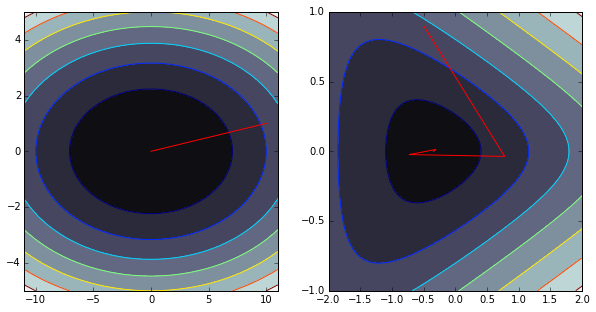

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plot_contour(quadratic, (-11, 11), (-5, 5), ax1)
plot_contour(nonquadratic, (-2, 2), (-1, 1), ax2)

xstar_q, x_steps_q, f_steps_q = newtons_method(quadratic, np.array([[10.0], [1.0]]), grad_quadratic, hessian_quadratic, epsilon=1e-8, trace=True)
add_path(ax1, x_steps_q, 'red')

print 'Number of steps quadratic function: %i' %len(x_steps_q)

xstar_nq, x_steps_nq, f_steps_nq = newtons_method(nonquadratic, np.array([[-0.5], [0.9]]), grad_nonquadratic, hessian_nonquadratic, epsilon=1e-8, trace=True)
add_path(ax2, x_steps_nq, 'red')

print 'Number of steps non-quadratic function: %i' %len(x_steps_nq)


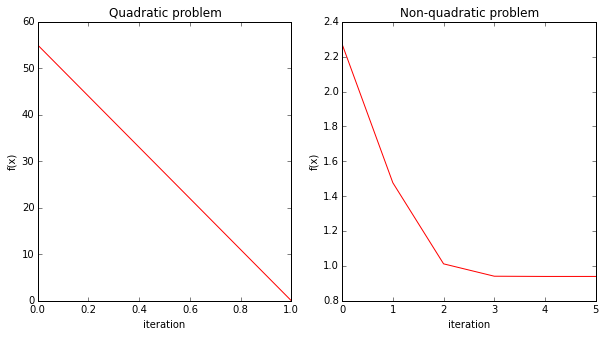

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.plot(f_steps_q, c='red')
ax1.set_title('Quadratic problem')
ax2.plot(f_steps_nq, c='red')
ax2.set_title('Non-quadratic problem')
for ax in (ax1, ax2):
    ax.set_xlabel('iteration')
    ax.set_ylabel('f(x)')
    #ax.semilogy()

## Lesson ideas
- define unconstrained optimization and convex problems
- descent and grascent methods
- (inexact) line search as a subroutine
- show that gradient descent works reasonably well when function is well conditioned (show with quadr. example)
- covariant algorithms => to Newton's algorithm (cfr. MacKay)
- convergence analysis
- project: logistic regression (both methods) MAKE LINK WITH REGULARIZATION (=makeing well conditioned!)

gradient descent iterations: 2
Newton's iterations: 2


<function __main__.show_condition>

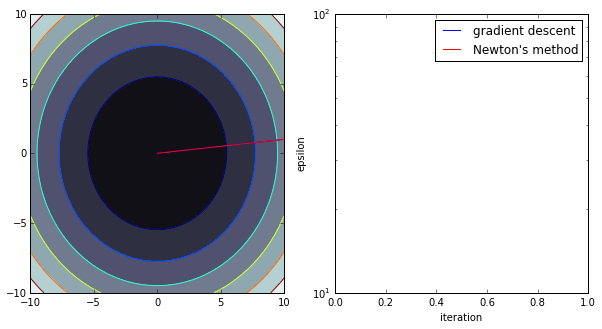

In [31]:
def show_condition(gamma):
    quad_gamma = lambda x : quadratic(x, gamma)
    d_quad_gamma = lambda x : grad_quadratic(x, gamma)
    dd_quad_gamma = lambda x : hessian_quadratic(x, gamma)
    xstar_gd, x_steps_gd, f_steps_gd = gradient_descent(quad_gamma, np.array([[10.0], [1.0]]),\
                                                     d_quad_gamma, nu=1e-6, trace=True)
    xstar_nm, x_steps_nm, f_steps_nm = newtons_method(quad_gamma, np.array([[10.0], [1.0]]),\
                                                   d_quad_gamma, dd_quad_gamma, epsilon=1e-6, trace=True)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    plot_contour(quad_gamma, [-10, 10], [-10, 10], ax1)
    add_path(ax1, x_steps_gd, 'b')
    ax2.plot(map(np.abs, f_steps_gd), c='b', label='gradient descent')
    add_path(ax1, x_steps_nm, 'r')
    ax2.plot(map(np.abs, f_steps_nm), c='r', label="Newton's method")
    ax2.set_xlabel('iteration')
    ax2.set_ylabel('epsilon')
    ax2.semilogy()
    ax2.legend(loc=0)
    print 'gradient descent iterations: %s' %len(x_steps_gd)
    print "Newton's iterations: %s" %len(x_steps_nm)

interact(show_condition, gamma=FloatSlider(min=0.1, max=20.0, step=0.1, value=1))

## Project

Logistic regression function:

$$
f(\mathbf{x};\mathbf{w}) = \sigma(\mathbf{w}^\intercal\mathbf{x})\\
     = \sigma(\sum_{j=1}^p w_j x_j)
$$

For logistic regression we seek to minimize:

$$
\mathcal{L}(\mathbf{w})=-\sum_{i=1}^n[y_i\log(\sigma(\mathbf{w}^\intercal\mathbf{x}_i))+(1-y_i)\log(1-\sigma(\mathbf{w}^\intercal\mathbf{x}_i))] +\lambda \mathbf{w}^\intercal\mathbf{w}\,,
$$

with
$$
\sigma(x) = \frac{e^{-x}}{1-e^{-x}}\,.
$$

We know that
$$
\frac{\partial \sigma(x)}{\partial x} = \sigma(x)(1-\sigma(x))\,
$$
hence

$$
\frac{\partial \mathcal{L}(\mathbf{w})}{\partial \mathbf{w}} =  \sum_{i=1}^n[y_i(1-\sigma(\mathbf{w}^\intercal\mathbf{x}_i))\mathbf{x}_i - (1-y_i)\sigma(\mathbf{w}^\intercal\mathbf{x}_i)\mathbf{x}_i]+2\lambda\mathbf{w}\,
$$

$$
\frac{\partial^2 \mathcal{L}(\mathbf{w})}{\partial \mathbf{w}^2} = \sum_{i=1}^n (\sigma(\mathbf{w}^\intercal\mathbf{x})(1-\sigma(\mathbf{w}^\intercal\mathbf{x}_i))\mathbf{x}_i\mathbf{x}_i^\intercal) +2\lambda \mathbf{I}\,.
$$

In [19]:
import pandas as pd

expression = pd.DataFrame.from_csv('../expression_remission.csv', index_col=None)
expression = expression.dropna()

X = expression.iloc[:, :-1].values[:,:1000]
# standardize X
X -= X.mean(0)
X /= X.std(0)
y = (expression.iloc[:, -1] == 'CR').values * 1.0

In [20]:
import theano
from theano import Param
from theano import tensor as T

Xobj = T.matrix('X')
yobj = T.vector('y')
wobj = T.vector('w')
lam = T.scalar('lam')

prediction = T.nnet.sigmoid(Xobj.dot(wobj))

loss = T.mean(T.nnet.binary_crossentropy(prediction, yobj)) + lam * T.sum(wobj**2)
logistic_loss = theano.function([wobj, Param(Xobj, default=X), Param(yobj, default=y), Param(lam, default=1e-1)], loss)
grad_logistic_loss = theano.function([wobj, Param(Xobj, default=X), Param(yobj, default=y), Param(lam, default=1e-1)], theano.grad(loss, wobj))
hessian_logistic_loss = theano.function([wobj, Param(Xobj, default=X), Param(yobj, default=y), Param(lam, default=1e-1)], theano.gradient.hessian(loss, wobj))
inv_diag_hessian_logistic_loss = theano.function([wobj, Param(Xobj, default=X), Param(yobj, default=y), Param(lam, default=1e-1)], theano.gradient.hessian(loss, wobj).diagonal()**-1)

## Using gradient descent

In [21]:
w_gd, x_steps_gd, f_steps_gd = gradient_descent(logistic_loss, np.zeros(X.shape[1]), grad_logistic_loss, nu=1e-5, alpha=0.2, beta=0.3, trace=True)

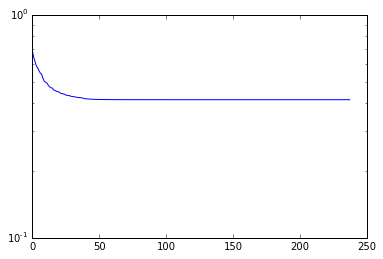

In [22]:
plt.plot(f_steps_gd)
plt.semilogy()

## Using Newton's algorithm

In [23]:
w_nm, x_steps_nm, f_steps_nm = newtons_method(logistic_loss, np.zeros(X.shape[1]), grad_logistic_loss, hessian_logistic_loss, epsilon=1e-5, trace=True)

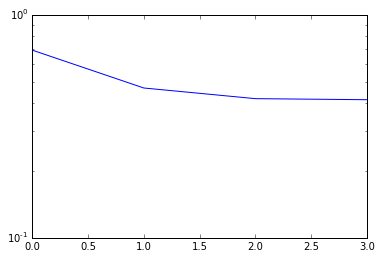

In [24]:
plt.plot(f_steps_nm)
plt.semilogy()

## Using the BFGS method

In [25]:
result_bfgs = minimize(logistic_loss, np.zeros(X.shape[1]), method='BFGS', jac=grad_logistic_loss)

In [26]:
print result_bfgs.keys()
result_bfgs['fun']

['status', 'success', 'njev', 'nfev', 'hess_inv', 'fun', 'x', 'message', 'jac', 'nit']


## Exercise: study of convergence of GD/NM

Here we will study the convergence rate of gradient descent versus newton's algorithm for different values of the regularization parameter $\lambda$ => condition number.

Futhermore, we will use an approximation of the hessian by using only the diagonal elements.

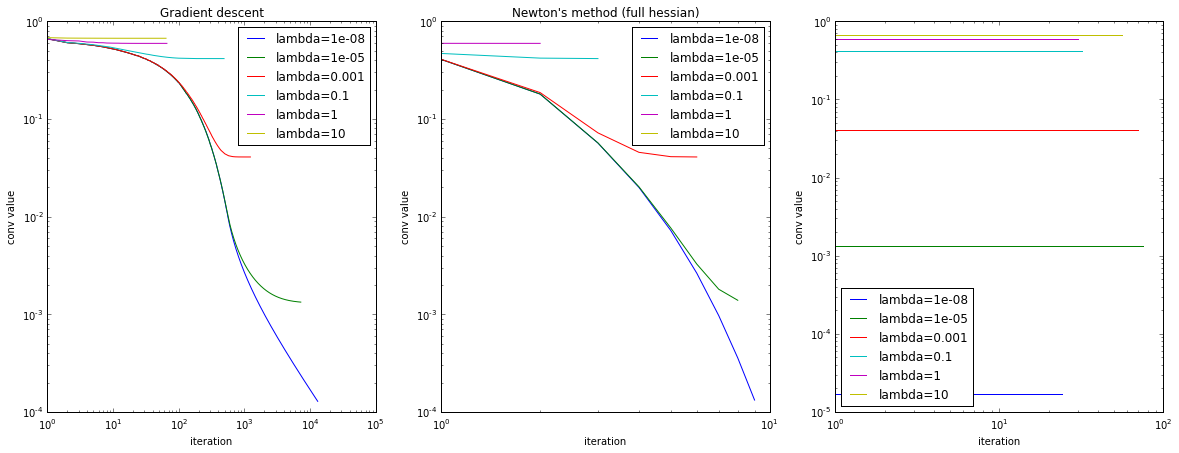

In [27]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 7))
axes[0].set_title('Gradient descent')
axes[1].set_title('Newton\'s method (full hessian)')
#axes[2].set_title('Newton\'s method (diagonal of hessian)')
    

for lam in [1e-8, 1e-5, 1e-3, 1e-1, 1, 10]:
    f = lambda w : logistic_loss(w, lam=lam)
    df = lambda w : grad_logistic_loss(w, lam=lam)
    ddf = lambda w : hessian_logistic_loss(w, lam=lam)
    invdiagddf = lambda w : np.diag(inv_diag_hessian_logistic_loss(w, lam=lam))
    
    w_gd, x_steps_gd, f_steps_gd = gradient_descent(f, np.zeros(X.shape[1]),
                                                    df,
                                                    nu=1e-4, trace=True)
    axes[0].plot(f_steps_gd, label='lambda=%s'%lam)
    
    w_nm, x_steps_nm, f_steps_nm = newtons_method(f, 
                                                  np.zeros(X.shape[1]), 
                                                  df, 
                                                  ddf, 
                                                  epsilon=1e-4, trace=True)
    axes[1].plot(f_steps_nm, label='lambda=%s'%lam)
    
    result_bfgs = minimize(f, np.zeros(X.shape[1]), method='BFGS', jac=df)
    
    axes[2].plot([1, result_bfgs['nfev']], [result_bfgs['fun'], result_bfgs['fun']], label='lambda=%s'%lam)
    
    '''
    w_nmd, x_steps_nmd, f_steps_nmd = newtons_method(f, 
                                                  np.zeros(X.shape[1]), 
                                                  df, 
                                                  invdiagddf, 
                                                  epsilon=1e-4, trace=True,
                                                    inverse_hess=True)
    axes[2].plot(f_steps_nmd, label='lambda=%s'%lam)    
    '''
    
for ax in axes:
    ax.set_xlabel('iteration')
    ax.loglog()
    ax.set_ylabel('conv value')
    ax.legend(loc=0)

In [28]:
lam = 1e-1
    
f = lambda w : logistic_loss(w, lam=lam)
df = lambda w : grad_logistic_loss(w, lam=lam)
ddf = lambda w : hessian_logistic_loss(w, lam=lam)
invdiagddf = lambda w : np.diag(inv_diag_hessian_logistic_loss(w, lam=lam))
    
%timeit w_nm, x_steps_nm, f_steps_nm = gradient_descent(f, np.zeros(X.shape[1]), df, nu=1e-4, trace=True)

1 loops, best of 3: 784 ms per loop


In [29]:
%timeit w_nm, x_steps_nm, f_steps_nm = newtons_method(f, np.zeros(X.shape[1]), df, ddf, epsilon=1e-4, trace=True)

1 loops, best of 3: 795 ms per loop


In [30]:
%timeit result_bfgs = minimize(f, np.zeros(X.shape[1]), method='BFGS', jac=grad_logistic_loss)

1 loops, best of 3: 4.15 s per loop
